In [1]:
import util
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from PIL import Image

ModuleNotFoundError: ignored

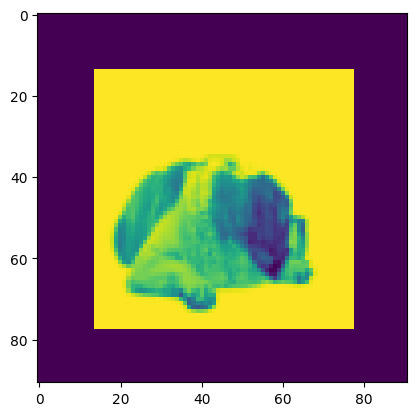

In [3]:
#loading in the dogs dataset
img = Image.open('dog_data/002431.png')
img, startX, startY = util.pad_img(img)
#plt.imshow(img, cmap='gray')
plt.imshow(img)


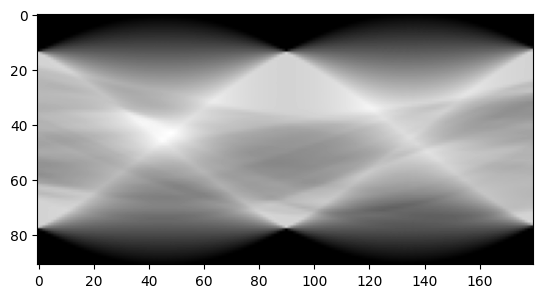

In [4]:
#img = Image.open('images/Brady-square.jpg')

angles = np.linspace(0,180,180,endpoint=False)
sinogram = util.projection(img, angles)

plt.imshow(sinogram, cmap='gray')

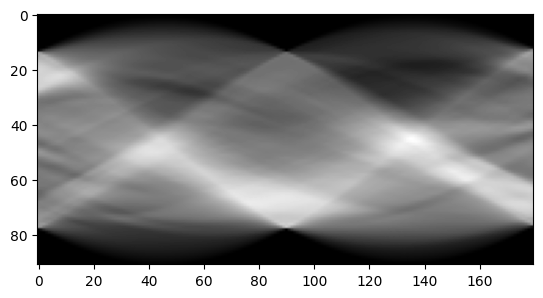

In [5]:
folder_path = "dog_data"
output_folder = "input_sinograms"

angles = np.linspace(0,180,180,endpoint=False)

# Loop through each file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".png"):
      image_path = os.path.join(folder_path, file_name)
      img = Image.open(image_path)
      
      img, startX, startY = util.pad_img(img)
      sinogram = util.projection(img, angles)

      plt.imshow(sinogram, cmap='gray')

      #save sinogram to input_sinograms
      output_path = os.path.join(output_folder, file_name)
      plt.savefig(output_path)


The next part is training the model on the sinograms that we just generated above.

In [20]:
#training helper functions

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import torch.nn as nn

# preprocess input images

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224)) # Resize to a common size
    if img.mode == 'RGBA':
        img = img.convert('RGB') # Convert RGBA images to RGB format
    img = np.array(img) / 255.0 # Normalize pixel values between 0 and 1
    return img.astype(np.float32) # Convert to NumPy array of dtype float32

dogs = []
sinograms = []

for filename in os.listdir("dog_data"):
    if filename.endswith('.png'):
      dog_image = Image.open(os.path.join("dog_data", filename))
      dog_image = preprocess_image(os.path.join("dog_data", filename))
      dogs.append(dog_image)

      sinogram_filename = filename[:-4] + "_sinogram.png"
      # print(sinogram_filename)
      # print(filename)
      sinogram = preprocess_image(os.path.join("input_sinograms", sinogram_filename))
      #print(sinogram.size)
      sinograms.append(sinogram)




dogs = np.array(dogs)
sinograms = np.array(sinograms)

# split input and output images into training and validation sets

val_split = 0.2 #val split ratio


X_train, X_val, y_train, y_val = train_test_split(dogs, sinograms, test_size=val_split, random_state=42)

# Split the dog data into training and validation sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# our model architecture

model = keras.Sequential(
    [
        layers.Input(shape=(224, 224, 3)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        # layers.MaxPooling2D(pool_size=(2, 2)),
      # layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
      # layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(3, kernel_size=(3, 3), activation="relu", padding="same")
        #Fully connected layer
        # layers.Dense(32, activation = "relu")
        
    ]
)

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

val_loss, val_acc = model.evaluate(X_val, y_val)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

y_pred = model.predict(X_val)


X_train shape: (31, 224, 224, 3)
y_train shape: (31, 224, 224, 3)
X_val shape: (8, 224, 224, 3)
y_val shape: (8, 224, 224, 3)
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.6549 - accuracy: 0.9727 - val_loss: 0.6112 - val_accuracy: 0.9939
Epoch 2/10
1/1 [==============================] - 5s 5s/step - loss: 0.6073 - accuracy: 0.9926 - val_loss: 0.5777 - val_accuracy: 0.9994
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 0.5697 - accuracy: 0.9970 - val_loss: 0.5498 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 0.5370 - accuracy: 0.9996 - val_loss: 0.5234 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 5s 5s/step - loss: 0.5057 - accuracy: 0.9999 - val_loss: 0.4988 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 0.4771 - accuracy: 1.0000 - val_loss: 0.4748 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 4s

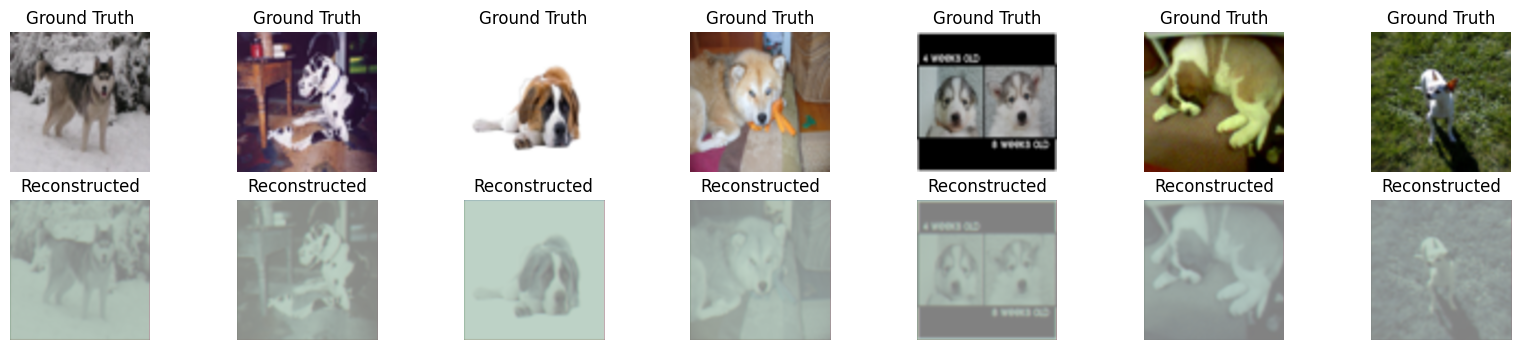

In [7]:
import matplotlib.pyplot as plt

n = 7 # number of images to visualize
plt.figure(figsize=(20, 4))
for i in range(n):
    # plot ground truth image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_val[i])
    plt.title("Ground Truth")
    plt.axis("off")
    
    # plot reconstructed image
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(y_pred[i])
    # print("y_pred.shape is ", y_pred.shape)
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()